# Predictive Analytics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# load prediction dataset
feature_data = pd.read_csv("prediction_data.csv",parse_dates=["start_time"], low_memory=False)
feature_data.head(1)

,start_time,month,day,hour,mean_duration,max_temp,precip,trips,isWeekday
0,2019-01-01,1.0,1.0,0.0,15.736842,15.6,0.0,19,0


## Feature Engineering

### Possible features could be:
1. Month/Season
2. Day
3. Hour
4. Duration
5. Temperature
6. Precipitation
7. Weekday/Weekend

Our target is the number of trips.

## Correlation Analysis

We analyze how strong the features are correlated to the target:

In [3]:
features = ['month', 'day', 'hour', 'mean_duration','max_temp','precip','isWeekday']
target = ['trips']

<AxesSubplot:>

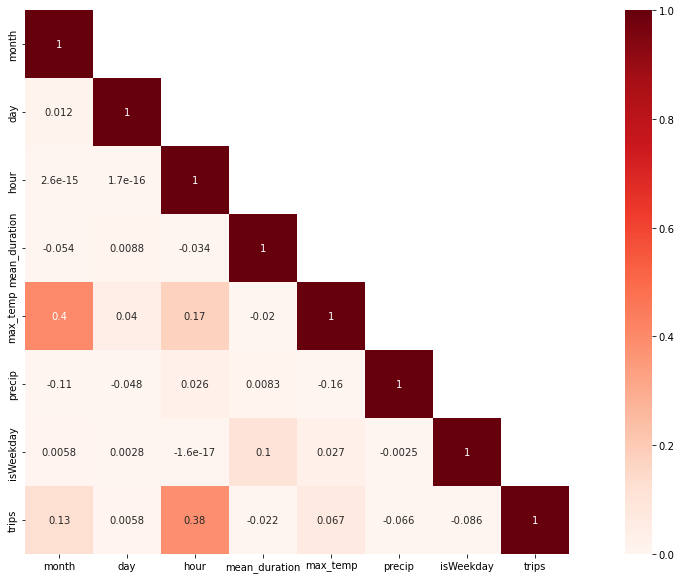

In [4]:
matrix = feature_data[features + target].corr()
heat = np.array(matrix)
heat[np.tril_indices_from(heat)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(matrix, mask=heat,vmax=1.0, vmin=0.0, square=True,annot=True, cmap="Reds")

The variables "hour", "month" and "max_temp" seem to be promising features for the bike sharing trip prediction.

We drop the 'start_time' column from our dataset, define our dependent (y) and independent (x) variables and normalize the data using sklearn package. Then, we split the dataset into training and testing sets and scale the values.

In [5]:
# Assigning and scaling the data
x = feature_data[['hour','month','max_temp']]
y = feature_data['trips'].values

In [6]:
# Splitting the data into train and test sets with 70% training set
# Set random_state=1
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=1)
scaler = StandardScaler()
x_scaled_train = pd.DataFrame(data=scaler.fit_transform(x_train), columns=x.columns)
x_scaled_test = pd.DataFrame(data=scaler.fit_transform(x_test), columns=x.columns)

## Polynomial Regression

First, we apply polynomial regression on the three features. We want to find the best degree of polynomial based on the MSE values. Therefore, we compute the train and test error.

In [7]:
# We assume a maximum degree of 12
number_degrees = [1,2,3,4,5,6,7,8,9,10,11,12]

# Create two empty lists to store training and test MSEs
training_error, test_error = [],[]

# Loop through the degrees of the polynomial to create different models
for d in number_degrees:
    
    # Compute the polynomial features 
    x_poly_train = PolynomialFeatures(degree = d).fit_transform(x_scaled_train)
    x_poly_test = PolynomialFeatures(degree = d).fit_transform(x_scaled_test)
    
    # Initialize a linear regression model and fit the model
    lreg = LinearRegression(fit_intercept=False)
    lreg.fit(x_poly_train, y_train)
    
    # Use the trained model to predict on the transformed data
    y_train_pred = lreg.predict(x_poly_train)
    y_test_pred = lreg.predict(x_poly_test)
    
    # Compute the MSEs
    training_error.append(mean_squared_error(y_train, y_train_pred))
    test_error.append(mean_squared_error(y_test, y_test_pred))
    
# compute the best degree (model with the lowest test error)
best_degree = test_error.index(min(test_error))
print("The best degree of the model is",best_degree)

The best degree of the model is 7


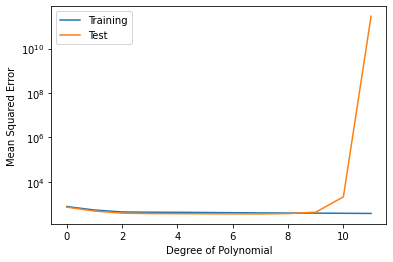

In [17]:
# Plot the errors as a function of increasing d value to visualise the training and testing errors
plt.figure()
plt.semilogy(range(12),training_error,range(12),test_error)
plt.xlabel("Degree of Polynomial")
plt.ylabel("Mean Squared Error")
plt.legend(["Training","Test"])
plt.savefig("Degree_Polynomial.png")
plt.show()

In [9]:
# Compute polynomial regression and evaluation metrics for degree d=7

x_poly_train = PolynomialFeatures(degree = 7).fit_transform(x_scaled_train)
x_poly_test = PolynomialFeatures(degree = 7).fit_transform(x_scaled_test)
# Initialize a linear regression model and fit the model
lreg = LinearRegression(fit_intercept=False)
lreg.fit(x_poly_train, y_train)
# Use the trained model to predict on the transformed data
y_test_pred = lreg.predict(x_poly_test)

print("Mean Squared Error:",mean_squared_error(y_test, y_test_pred))
print("R score:",r2_score(y_test, y_test_pred))
print("Mean Absolute Error:",mean_absolute_error(y_test,y_test_pred))

Mean Squared Error: 358.35585295415984
R score: 0.589315787288678
Mean Absolute Error: 12.033775226128016


## Random Forest Regression

We select all features for the random forest regression.

In [10]:
# Assigning and scaling the data
x = feature_data[['hour','month','max_temp','day','mean_duration','precip','isWeekday']]
y = feature_data['trips'].values
# Splitting the data into train and test sets with 70% training set
# Set random_state=1
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=1)
scaler = StandardScaler()
x_scaled_train = pd.DataFrame(data=scaler.fit_transform(x_train), columns=x_train.columns)
x_scaled_test = pd.DataFrame(data=scaler.fit_transform(x_test), columns=x_test.columns)

In [11]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100) # Workshop: (n_estimators=10000,bootstrap=True)
rf.fit(x_scaled_train,y_train)
y_predicted_r = rf.predict(x_scaled_test)

print("Mean Squared Error:",mean_squared_error(y_test, y_predicted_r))
print("R score:",r2_score(y_test, y_predicted_r))
print("Mean Absolute Error:",mean_absolute_error(y_test,y_predicted_r))

Mean Squared Error: 382.3920987062405
R score: 0.5617696858873655
Mean Absolute Error: 10.976095890410958


In [12]:
# see if bootstrap has an impact
rf = RandomForestRegressor(n_estimators=100,bootstrap=True) # Workshop: (n_estimators=10000(default:100),bootstrap=True)
rf.fit(x_scaled_train,y_train)
y_predicted_r = rf.predict(x_scaled_test)

print("Mean Squared Error:",mean_squared_error(y_test, y_predicted_r))
print("R score:",r2_score(y_test, y_predicted_r))
print("Mean Absolute Error:",mean_absolute_error(y_test,y_predicted_r))

Mean Squared Error: 376.8686262937595
R score: 0.5680997148249496
Mean Absolute Error: 10.928595890410959


Slightly better results with Bootstrap.

###  Feature importance of Random Forest Regression

We analyze which features are most important for random forest regression.

In [13]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [14]:
# Print the feature ranking
print("Feature ranking:")
for f in range(x_scaled_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature month (0.561834)
2. feature max_temp (0.131893)
3. feature hour (0.095860)
4. feature day (0.086131)
5. feature mean_duration (0.082882)
6. feature isWeekday (0.030178)
7. feature precip (0.011222)


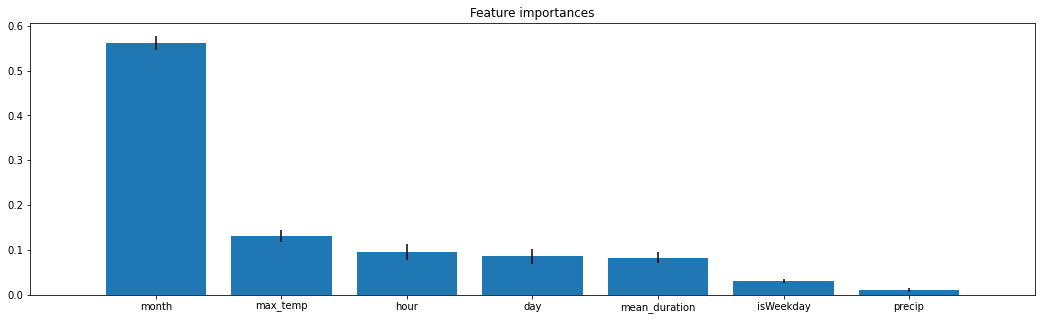

In [18]:
# Plot the feature importances of the forest
plt.figure(figsize=(18,5))
plt.title("Feature importances")
plt.bar(range(x_scaled_train.shape[1]), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(x_scaled_train.shape[1]), [features[i] for i in indices])
plt.xlim([-1, x_scaled_train.shape[1]])
plt.savefig("RF_Regr_Feature_Importance.png")
plt.show()

The result corresponds to the high correlation of the month,max_temp and hour variable with the bicycle sharing count in the feature correlation matrix.